## Classification

#### Authors: 
Guilherme Amaral Hiromoto

Paulo Matana da Rocha 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler , StandardScaler

## heart.csv

https://www.kaggle.com/ronitf/heart-disease-uci

### Read inputs and preprocessing data 

In [2]:
data = pd.read_csv("heart.csv")
data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [3]:
X = np.array(data[data.columns[0:data.shape[1]-1]])
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = data['target']
classes = np.array(pd.unique(data[data.columns[-1]]), dtype=int)

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

### Parametric bayes classifier

In [5]:
from scipy.stats import multivariate_normal

P = pd.DataFrame(data=np.zeros((x_test.shape[0], 2)), columns=classes) 

Pc = np.zeros(len(classes)) 
for i in np.arange(0, len(classes)):
    elements = tuple(np.where(y_train == classes[i]))
    Pc[i] = len(elements)/len(y_train)
    Z = x_train[elements,:][0]
    m = np.mean(Z, axis = 0)
    cv = np.cov(np.transpose(Z))
    for j in np.arange(0,x_test.shape[0]):
        x = x_test[j,:]
        pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)
        P[classes[i]][j] = pj*Pc[i]

In [6]:
y_pred = []

for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred, dtype=np.int64)

In [7]:
from sklearn.metrics import accuracy_score

score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.8360655737704918


### Non-Parametric bayes classifier

In [8]:
from sklearn.neighbors import KernelDensity

P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 
Pc = np.zeros(len(classes)) 
h = 2
# For each class
for i in np.arange(0, len(classes)): 
    elements = tuple(np.where(y_train == classes[i])) 
    Pc[i] = len(elements)/len(y_train) # Probability to belong to class i
    Z = x_train[elements,:][0]
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Z)
    for j in np.arange(0,x_test.shape[0]): # for each observation in the test set
        x = x_test[j,:]
        x = x.reshape((1,len(x)))
        # probability belong to each class
        pj = np.exp(kde.score_samples(x)) 
        P[classes[i]][j] = pj*Pc[i]

In [9]:
y_pred = []

for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])

y_pred = np.array(y_pred, dtype=np.int64)

In [10]:
from sklearn.metrics import accuracy_score

score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.8360655737704918


### Naive-bayes classifier

In [11]:
def gaussian(x, mu, sig):
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def likelyhood(y, Z):
    prob = 1
    for j in np.arange(0, Z.shape[1]):
        m = np.mean(Z[:,j])
        s = np.std(Z[:,j])      
        prob = prob*gaussian(y[j], m, s)
    return prob

In [12]:
P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 

for i in np.arange(0, len(classes)):
    elements = tuple(np.where(y_train == classes[i]))
    Z = x_train[elements,:][0]
    for j in np.arange(0,x_test.shape[0]):
        x = x_test[j,:]
        pj = likelyhood(x,Z)
        P[classes[i]][j] = pj*len(elements)/x_train.shape[0]

In [13]:
y_pred = []
for i in np.arange(0, P.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(P.columns[c])
y_pred = np.array(y_pred, dtype=np.int64)

In [14]:
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.7704918032786885


## diabetes.csv

https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [15]:
data = pd.read_csv("diabetes.csv")
data.isna().sum()
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [16]:
X = np.array(data[data.columns[0:data.shape[1]-1]])
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = data['Outcome']
classes = np.array(pd.unique(data[data.columns[-1]]), dtype=int)

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

In [18]:
from sklearn.neighbors import KernelDensity

P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 
Pc = np.zeros(len(classes))

accuracy = []
vh = np.arange (0.1,5.0,0.1)

# For 50 different h's
for h in vh:
    # For each class
    for i in np.arange(0, len(classes)): 
        elements = tuple(np.where(y_train == classes[i])) 
        Pc[i] = len(elements)/len(y_train) # Probability to belong to class i
        Z = x_train[elements,:][0]
        kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Z)
        for j in np.arange(0,x_test.shape[0]): # for each observation in the test set
            x = x_test[j,:]
            x = x.reshape((1,len(x)))
            # probability belong to each class
            pj = np.exp(kde.score_samples(x)) 
            P[classes[i]][j] = pj*Pc[i]

    y_pred = []

    for i in np.arange(0, x_test.shape[0]):
        c = np.argmax(np.array(P.iloc[[i]]))
        y_pred.append(classes[c])

    y_pred = np.array(y_pred, dtype=np.int64)

    accuracy.append(accuracy_score(y_pred, y_test))

Best h: 0.30000000000000004
Best accuracy: 0.7337662337662337


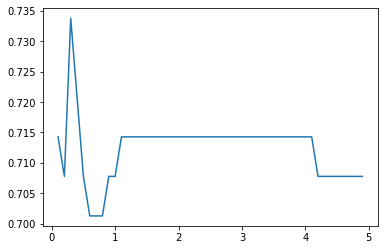

In [19]:
plt.plot(vh,accuracy)
max_value = np.max(accuracy)
best_h = vh[np.argmax(np.array(accuracy))]
print(f'Best h: {best_h}\nBest accuracy: {max_value}')
plt.show()

## Noise influence (Parametric, Non-parametric and Naive-Bayes)

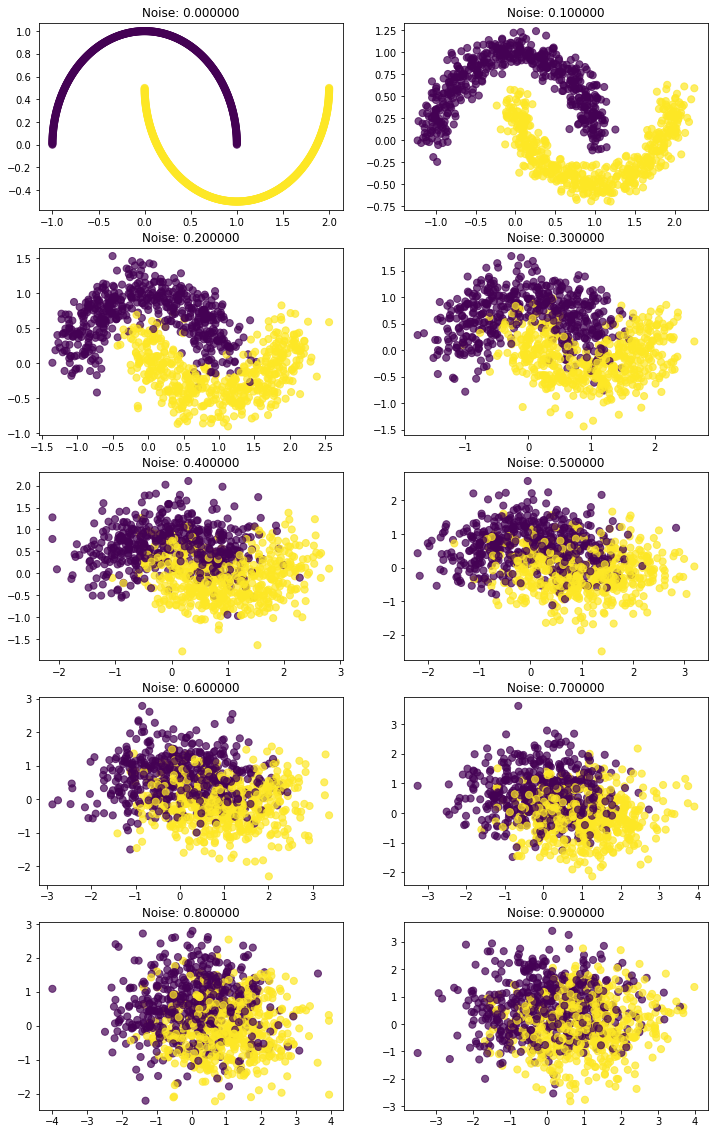

In [20]:
from sklearn import datasets
import matplotlib.pyplot as plt
noises = np.arange(0,1,0.1)
i = 1
f = plt.figure(figsize=(12,20))
for noise in noises:
    f.add_subplot(5,2,i)
    n_samples = 1000
    data = datasets.make_moons(n_samples=n_samples, noise=noise)
    X = data[0]
    y = data[1]
    i += 1
    
    
    plt.title("Noise: %f" %(noise))
    plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50, alpha=0.7)
plt.show(True)

In [21]:
def parametric_bayes(x_train, y_train, classes):
    P = pd.DataFrame(data=np.zeros((x_test.shape[0], 2)), columns=classes) 
    Pc = np.zeros(len(classes))

    for i in np.arange(0, len(classes)):
        elements = tuple(np.where(y_train == classes[i]))
        Pc[i] = len(elements)/len(y_train)
        Z = x_train[elements,:][0]
        m = np.mean(Z, axis = 0)
        cv = np.cov(np.transpose(Z))
        for j in np.arange(0,x_test.shape[0]):
            x = x_test[j,:]
            pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)
            P[classes[i]][j] = pj*Pc[i]

    y_pred = []

    for i in np.arange(0, x_test.shape[0]):
        c = np.argmax(np.array(P.iloc[[i]]))
        y_pred.append(classes[c])

    return np.array(y_pred, dtype=np.int64)

In [22]:
def non_parametric_bayes(x_train, y_train, classes):
    P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 
    Pc = np.zeros(len(classes)) 
    h = 2
    # For each class
    for i in np.arange(0, len(classes)): 
        elements = tuple(np.where(y_train == classes[i])) 
        Pc[i] = len(elements)/len(y_train) # Probability to belong to class i
        Z = x_train[elements,:][0]
        kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Z)
        for j in np.arange(0,x_test.shape[0]): # for each observation in the test set
            x = x_test[j,:]
            x = x.reshape((1,len(x)))
            # probability belong to each class
            pj = np.exp(kde.score_samples(x)) 
            P[classes[i]][j] = pj*Pc[i]

    y_pred = []

    for i in np.arange(0, x_test.shape[0]):
        c = np.argmax(np.array(P.iloc[[i]]))
        y_pred.append(classes[c])

    return np.array(y_pred, dtype=np.int64)

In [23]:
def naive_bayes(x_train, y_train, classes):
    P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 

    for i in np.arange(0, len(classes)):
        elements = tuple(np.where(y_train == classes[i]))
        Z = x_train[elements,:][0]
        for j in np.arange(0,x_test.shape[0]):
            x = x_test[j,:]
            pj = likelyhood(x,Z)
            P[classes[i]][j] = pj*len(elements)/x_train.shape[0]
    y_pred = []
    for i in np.arange(0, P.shape[0]):
        c = np.argmax(np.array(P.iloc[[i]]))
        y_pred.append(P.columns[c])
    
    return np.array(y_pred, dtype=np.int64)

In [24]:
noises = np.arange(0,1,0.1)
score_par = []
score_npar = []
score_nai = []

for noise in noises:
    n_samples = 1000
    data = datasets.make_moons(n_samples=n_samples, noise=noise)
    X = data[0]
    y = data[1]
    classes = np.array(pd.unique(data[1]), dtype=int)
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)
    
    y_pred_par = parametric_bayes(x_train, y_train, classes)
    y_pred_npar = non_parametric_bayes(x_train, y_train, classes)
    y_pred_nai = naive_bayes(x_train, y_train, classes)
    
    score_par.append(accuracy_score(y_pred_par, y_test))
    score_npar.append(accuracy_score(y_pred_npar, y_test))
    score_nai.append(accuracy_score(y_pred_nai, y_test))

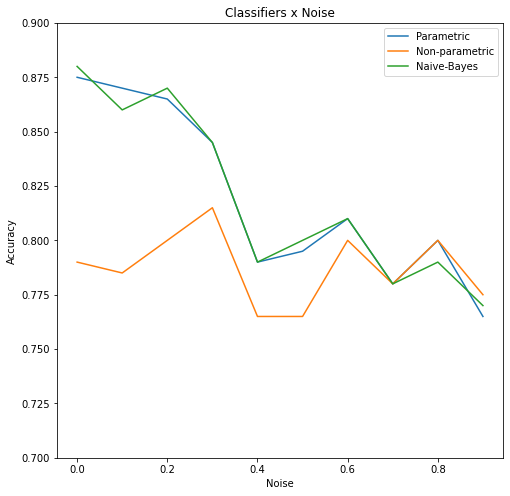

In [25]:
plt.figure(figsize=(8,8))
plt.title("Classifiers x Noise")
plt.plot(noises,score_par, label = "Parametric")
plt.plot(noises,score_npar, label = "Non-parametric")
plt.plot(noises,score_nai, label = "Naive-Bayes")
plt.ylabel('Accuracy')
plt.xlabel('Noise')
plt.ylim(0.70,0.9)
plt.legend()
plt.plot(True)

## Decision Boundaries

#### Logistic Regression

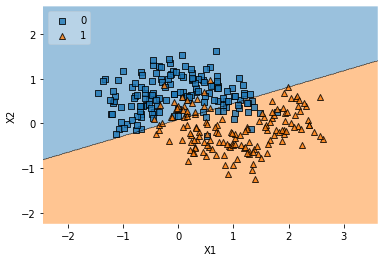

In [26]:
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression

noise = 0.3

data = datasets.make_moons(n_samples=300, noise=noise)
X = data[0]
y = data[1]

model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
model.fit(X, y)

plot_decision_regions(X, y, clf=model, legend=2)
plt.xlabel('X1')
plt.ylabel('X2')

plt.show()

#### Naive-Bayes

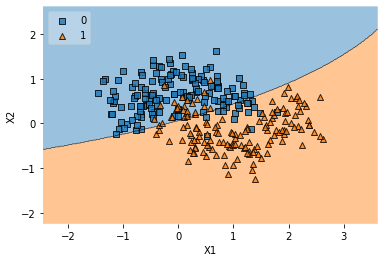

In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

model = GaussianNB()
model.fit(X, y)

plot_decision_regions(X, y, clf=model, legend=2)
plt.xlabel('X1')
plt.ylabel('X2')

plt.show()

#### KNN

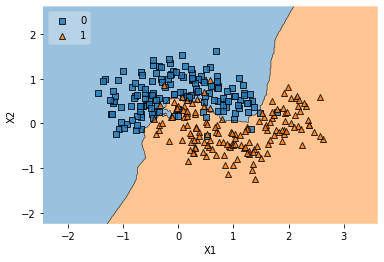

In [28]:
from sklearn.neighbors import KNeighborsClassifier

vk = range(2,10)
score = []

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

for k in vk:
    # Training a classifier
    model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    score.append(accuracy_score(y_pred, y_test))
    
model = KNeighborsClassifier(n_neighbors=vk[np.argmax(score)], metric = 'euclidean')
model.fit(x_train, y_train)

plot_decision_regions(X, y, clf=model, legend=2)
plt.xlabel('X1')
plt.ylabel('X2')

plt.show()

## Center Distance

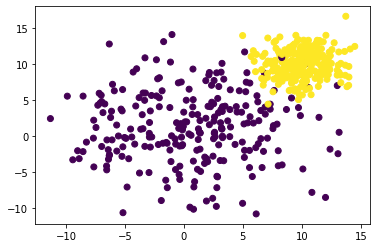

In [29]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
n = 500
c = [(1,1), (10,10)] #center of the points
std = [5.0, 2] # standard deviation
nc = [400,50] #number of points in each class
X, y = make_blobs(n_samples=n, n_features=2, cluster_std=std,centers= c)
plt.scatter(X[:,0],X[:,1], c=y)
plt.show(True)

#### Naive-Bayes vs Parametric Bayes Classifier

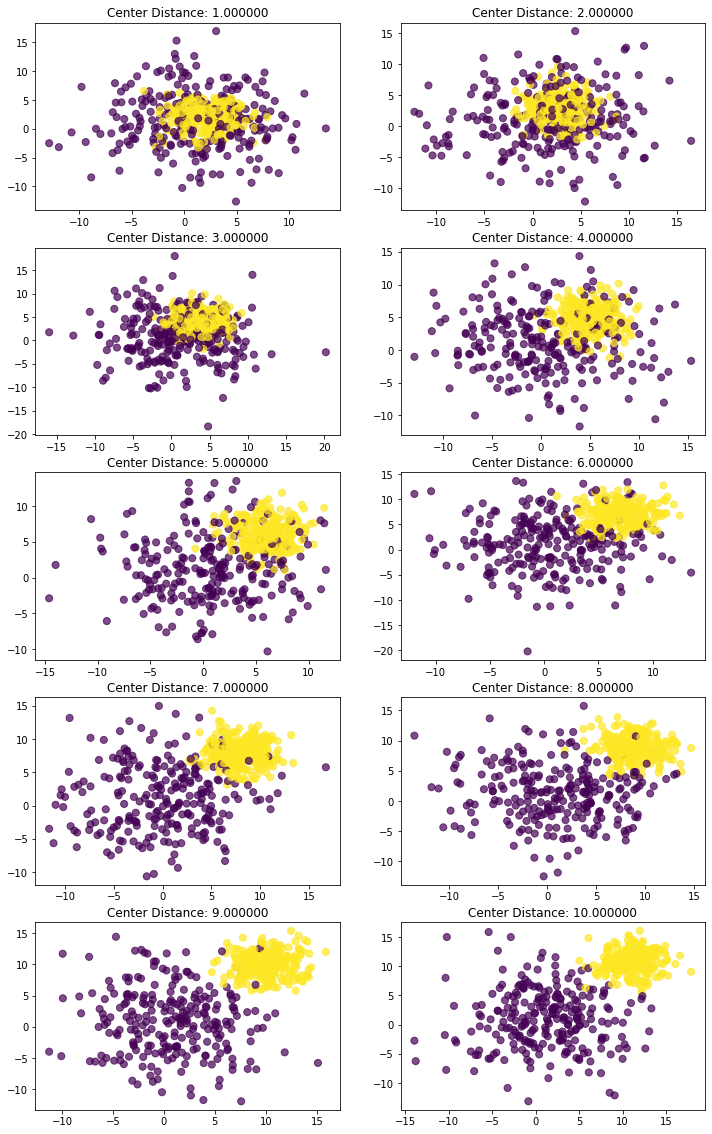

In [30]:
score_par = []
score_nai = []

center_distance = range(2,12)

f = plt.figure(figsize=(12,20))
for i in center_distance:
    n = 500
    c = [(1,1), (i,i)] #center of the points
    std = [5.0, 2] # standard deviation
    nc = [400,50] #number of points in each class
    X, y = make_blobs(n_samples=n, n_features=2, cluster_std=std,centers= c)
    f.add_subplot(5,2,i-1)
    plt.title("Center Distance: %f" %(i-1))
    plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50, alpha=0.7)

    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)
    
    y_pred_par = parametric_bayes(x_train, y_train, classes)
    y_pred_nai = naive_bayes(x_train, y_train, classes)

    score_par.append(accuracy_score(y_pred_par, y_test))
    score_nai.append(accuracy_score(y_pred_nai, y_test))
plt.show()

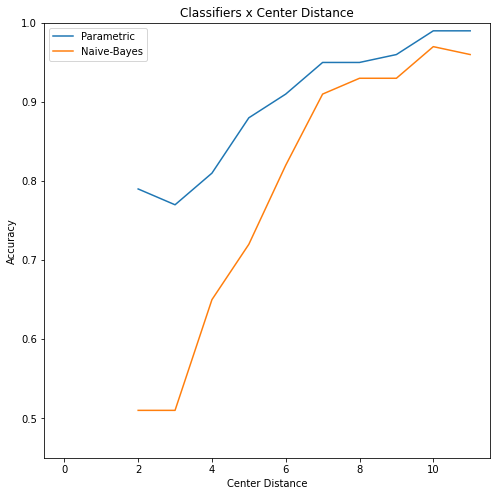

In [31]:
plt.figure(figsize=(8,8))
plt.title("Classifiers x Center Distance")
plt.plot(center_distance,score_par, label = "Parametric")
plt.plot(center_distance,score_nai, label = "Naive-Bayes")
plt.ylabel('Accuracy')
plt.xlabel('Center Distance')
plt.ylim(0.45,1.0)
plt.legend()
plt.plot(True)

## Noise influence (Naive-Bayes, KNN and Logistic Regression)

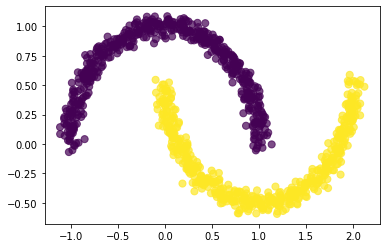

In [32]:
from sklearn import datasets
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
n_samples = 1000
data = datasets.make_moons(n_samples=n_samples, noise=.05)
X = data[0]
y = data[1]
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50, alpha=0.7)
plt.show(True)

In [33]:
from sklearn.model_selection import GridSearchCV

noises = np.arange(0,1,0.1)
score_nai = []
score_knn = []
score_logr = []

for noise in noises:
    n_samples = 1000
    data = datasets.make_moons(n_samples=n_samples, noise=noise)
    X = data[0]
    y = data[1]
    classes = np.array(pd.unique(data[1]), dtype=int)
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)
    
    ## Naive-Bayes
    model = GaussianNB()
    model.fit(x_train,y_train)
    y_pred_nai = model.predict(x_test)
    
    #Logistic Regression
    model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
    model.fit(x_train, y_train)
    y_pred_logr = model.predict(x_test) 
    
    #KNN with GridSearch
    k_range = list(range(1, 21))
    param_grid = dict(n_neighbors=k_range)
    knn = KNeighborsClassifier(n_neighbors= 20)
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False)
    grid.fit(x_train, y_train)
    y_pred_knn = grid.predict(x_test)
    
    score_nai.append(accuracy_score(y_pred_nai, y_test))
    score_logr.append(accuracy_score(y_pred_logr, y_test))
    score_knn.append(accuracy_score(y_pred_knn, y_test))

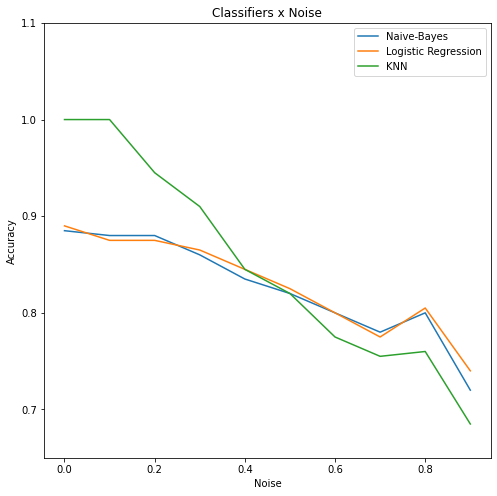

In [34]:
plt.figure(figsize=(8,8))
plt.title("Classifiers x Noise")
plt.plot(noises,score_nai, label = "Naive-Bayes")
plt.plot(noises,score_logr, label = "Logistic Regression")
plt.plot(noises,score_knn, label = "KNN")
plt.ylabel('Accuracy')
plt.xlabel('Noise')
plt.ylim(0.65,1.1)
plt.legend()
plt.plot(True)

## Decision Tree, Random Forest and Bagging

In [35]:
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

noises = np.arange(0,1,0.1)
score_dect = []
score_ranf = []
score_bagg = []

for noise in noises:
    n_samples = 1000
    data = datasets.make_moons(n_samples=n_samples, noise=noise)
    X = data[0]
    y = data[1]
    classes = np.array(pd.unique(data[1]), dtype=int)
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)
    
    ## Decision Tree
    model = tree.DecisionTreeClassifier(criterion = 'gini', random_state = 42)
    model.fit(x_train, y_train)
    y_pred_dect = model.predict(x_test)
    
    ## Random Forest
    model=RandomForestClassifier(n_estimators=100, bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
    model.fit(x_train,y_train)
    y_pred_ranf = model.predict(x_test)
    
    ## Bagging
    model = BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(criterion = 'entropy',
                              random_state = 42),n_estimators=10)
    model.fit(x_train,y_train)
    y_pred_bagg = model.predict(x_test)
    
    score_dect.append(accuracy_score(y_pred_dect, y_test))
    score_ranf.append(accuracy_score(y_pred_ranf, y_test))
    score_bagg.append(accuracy_score(y_pred_bagg, y_test))

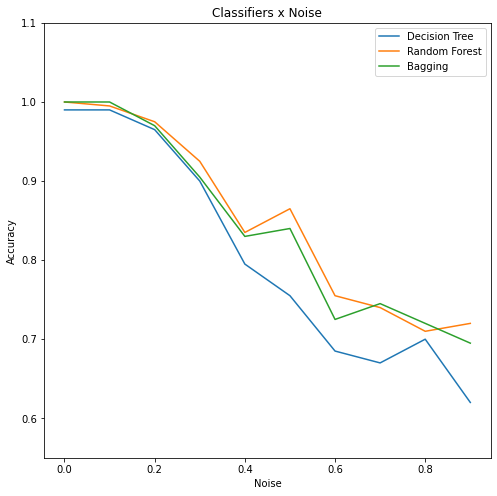

In [36]:
plt.figure(figsize=(8,8))
plt.title("Classifiers x Noise")
plt.plot(noises,score_dect, label = "Decision Tree")
plt.plot(noises,score_ranf, label = "Random Forest")
plt.plot(noises,score_bagg, label = "Bagging")
plt.ylabel('Accuracy')
plt.xlabel('Noise')
plt.ylim(0.55,1.1)
plt.legend()
plt.plot(True)

## Evaluation Metrics

#### Vehicle

In [37]:
data = pd.read_csv("Vehicle.csv")
data.isna().sum()

Comp            0
Circ            0
D.Circ          0
Rad.Ra          0
Pr.Axis.Ra      0
Max.L.Ra        0
Scat.Ra         0
Elong           0
Pr.Axis.Rect    0
Max.L.Rect      0
Sc.Var.Maxis    0
Sc.Var.maxis    0
Ra.Gyr          0
Skew.Maxis      0
Skew.maxis      0
Kurt.maxis      0
Kurt.Maxis      0
Holl.Ra         0
Class           0
dtype: int64

In [38]:
from sklearn.preprocessing import LabelEncoder  

X = np.array(data[data.columns[0:data.shape[1]-1]])
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = data['Class']

classes = np.array(pd.unique(y), dtype=str)

In [39]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

## Naive-Bayes
model = GaussianNB()
model.fit(x_train,y_train)
y_pred_nai = model.predict(x_test)

## Random Forest
model=RandomForestClassifier(n_estimators=100, bootstrap=True, class_weight=None, criterion='gini',
        max_depth=None, max_features='auto', max_leaf_nodes=None,
        min_impurity_decrease=0.0, min_impurity_split=None,
        min_samples_leaf=1, min_samples_split=2,
        min_weight_fraction_leaf=0.0, n_jobs=1,
        oob_score=False, random_state=None, verbose=0,
        warm_start=False)
model.fit(x_train,y_train)
y_pred_ranf = model.predict(x_test)

## KNN with GridSearch
k_range = list(range(1, 21))
param_grid = dict(n_neighbors=k_range)
knn = KNeighborsClassifier(n_neighbors= 20)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(x_train, y_train)
y_pred_knn = grid.predict(x_test)

## Logistic regression
model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
model.fit(x_train, y_train)
y_pred_logr = model.predict(x_test)

classifiers = ["Naive-Bayes", "Random Forest", "KNN", "Log. Regression"]
y_preds = [y_pred_nai, y_pred_ranf, y_pred_knn, y_pred_logr]

data = {}
for classifier in classifiers:
    data[classifier] = []

for i in range(len(y_preds)):
    data[classifiers[i]].append(accuracy_score(y_preds[i], y_test))
    data[classifiers[i]].append(precision_score(y_preds[i], y_test, average='macro'))
    data[classifiers[i]].append(f1_score(y_preds[i], y_test, average='macro'))
    #data[classifiers[i]].append(roc_auc_score(y_preds[i], y_test))
df1 = pd.DataFrame(data)
df1.index = ['Accuracy', 'Precision', 'F1']

In [41]:
df1

,Naive-Bayes,Random Forest,KNN,Log. Regression
Accuracy,0.500000,0.735294,0.694118,0.735294
Precision,0.518670,0.711859,0.686859,0.732452
F1,0.460142,0.703376,0.664319,0.704777


#### Vertebral Column-3C

In [42]:
data = pd.read_csv("vertebralcolumn-3C.csv")
data.isna().sum()

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
class                       0
dtype: int64

In [43]:
X = np.array(data[data.columns[0:data.shape[1]-1]])
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = data['class']
classes = np.array(pd.unique(data[data.columns[-1]]), dtype=str)

In [44]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

In [45]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

## Naive-Bayes
model = GaussianNB()
model.fit(x_train,y_train)
y_pred_nai = model.predict(x_test)
y_pred_prob = model.predict_proba(x_test)

## Random Forest
model=RandomForestClassifier(n_estimators=100, bootstrap=True, class_weight=None, criterion='gini',
        max_depth=None, max_features='auto', max_leaf_nodes=None,
        min_impurity_decrease=0.0, min_impurity_split=None,
        min_samples_leaf=1, min_samples_split=2,
        min_weight_fraction_leaf=0.0, n_jobs=1,
        oob_score=False, random_state=None, verbose=0,
        warm_start=False)
model.fit(x_train,y_train)
y_pred_ranf = model.predict(x_test)

## KNN with GridSearch
k_range = list(range(1, 21))
param_grid = dict(n_neighbors=k_range)
knn = KNeighborsClassifier(n_neighbors= 20)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(x_train, y_train)
y_pred_knn = grid.predict(x_test)

## Logistic regression
model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
model.fit(x_train, y_train)
y_pred_logr = model.predict(x_test)

classifiers = ["Naive-Bayes", "Random Forest", "KNN", "Log. Regression"]
y_preds = [y_pred_nai, y_pred_ranf, y_pred_knn, y_pred_logr]

data = {}
for classifier in classifiers:
    data[classifier] = []

for i in range(len(y_preds)):
    data[classifiers[i]].append(accuracy_score(y_preds[i], y_test))
    data[classifiers[i]].append(precision_score(y_preds[i], y_test, average='macro'))
    data[classifiers[i]].append(f1_score(y_preds[i], y_test, average='macro'))
    #data[classifiers[i]].append(roc_auc_score(y_preds[i], y_test))
df2 = pd.DataFrame(data)

In [46]:
df2.index = ['Accuracy', 'Precision', 'F1']
df2

,Naive-Bayes,Random Forest,KNN,Log. Regression
Accuracy,0.870968,0.838710,0.758065,0.774194
Precision,0.824074,0.777778,0.709491,0.684028
F1,0.825859,0.776833,0.701634,0.700918


#### Wine Quality-red

In [47]:
data = pd.read_csv("winequality-red.csv")
data.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [48]:
data.drop(data.index[data['quality'] == 3], inplace = True)
X = np.array(data[data.columns[0:data.shape[1]-1]])
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
classes = [4,5,6,7,8]
y = data['quality']

In [49]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

In [50]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

## Naive-Bayes
model = GaussianNB()
model.fit(x_train,y_train)
y_pred_nai = model.predict(x_test)
y_pred_prob = model.predict_proba(x_test)

## Random Forest
model=RandomForestClassifier(n_estimators=100, bootstrap=True, class_weight=None, criterion='gini',
        max_depth=None, max_features='auto', max_leaf_nodes=None,
        min_impurity_decrease=0.0, min_impurity_split=None,
        min_samples_leaf=1, min_samples_split=2,
        min_weight_fraction_leaf=0.0, n_jobs=1,
        oob_score=False, random_state=None, verbose=0,
        warm_start=False)
model.fit(x_train,y_train)
y_pred_ranf = model.predict(x_test)

## KNN with GridSearch
k_range = list(range(1, 21))
param_grid = dict(n_neighbors=k_range)
knn = KNeighborsClassifier(n_neighbors= 20)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(x_train, y_train)
y_pred_knn = grid.predict(x_test)

## Logistic regression
model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
model.fit(x_train, y_train)
y_pred_logr = model.predict(x_test)

classifiers = ["Naive-Bayes", "Random Forest", "KNN", "Log. Regression"]
y_preds = [y_pred_nai, y_pred_ranf, y_pred_knn, y_pred_logr]

data = {}
for classifier in classifiers:
    data[classifier] = []
    
for i in range(len(y_preds)):
    data[classifiers[i]].append(accuracy_score(y_preds[i], y_test))
    data[classifiers[i]].append(precision_score(y_preds[i], y_test, average='macro'))
    data[classifiers[i]].append(f1_score(y_preds[i], y_test, average='macro'))
df3 = pd.DataFrame(data)

In [51]:
df3.index = ['Accuracy', 'Precision', 'F1']
df3

,Naive-Bayes,Random Forest,KNN,Log. Regression
Accuracy,0.503145,0.704403,0.676101,0.569182
Precision,0.340447,0.516108,0.523818,0.287345
F1,0.319671,0.517347,0.518567,0.280223


## Cross Validation

Counter({0: 9900, 1: 100})


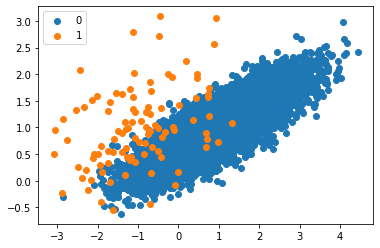

In [84]:
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# summarize class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
    pyplot.legend()
pyplot.show()

In [85]:
model_nb = GaussianNB()
model_logr = LogisticRegression()

In [86]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

scores_roc_nb = cross_val_score(model_nb, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_prec_nb = cross_val_score(model_nb, X, y, scoring='precision', cv=cv, n_jobs=-1)
scores_f1_nb = cross_val_score(model_nb, X, y, scoring='f1', cv=cv, n_jobs=-1)
scores_acc_nb = cross_val_score(model_nb, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

scores_roc_logr = cross_val_score(model_logr, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_prec_logr = cross_val_score(model_logr, X, y, scoring='precision', cv=cv, n_jobs=-1)
scores_f1_logr = cross_val_score(model_logr, X, y, scoring='f1', cv=cv, n_jobs=-1)
scores_acc_logr = cross_val_score(model_logr, X, y, scoring='accuracy', cv=cv, n_jobs=-1)


print(f"Naive Bayes AUC score: {mean(scores_roc_nb)}")
print(f"Naive Bayes Precision Score: {mean(scores_prec_nb)}")
print(f"Naive Bayes F1 Score: {mean(scores_f1_nb)}")
print(f"Naive Bayes Accuracy Score: {mean(scores_acc_nb)}\n")

print(f"Logistic Regression AUC score: {mean(scores_roc_logr)}")
print(f"Logistic Regression Precision Score: {mean(scores_prec_logr)}")
print(f"Logistic Regression F1 Score: {mean(scores_f1_logr)}")
print(f"Logistic Regression Accuracy Score: {mean(scores_acc_logr)}")

Naive Bayes AUC score: 0.9317062822076121
Naive Bayes Precision Score: 0.39861111111111114
Naive Bayes F1 Score: 0.28442312581900675
Naive Bayes Accuracy Score: 0.9884000000000001

Logistic Regression AUC score: 0.9472431140005823
Logistic Regression Precision Score: 0.9542424242424243
Logistic Regression F1 Score: 0.6168153415212239
Logistic Regression Accuracy Score: 0.9945999999999999


In [88]:
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

scores_roc_nb = cross_val_score(model_nb, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_prec_nb = cross_val_score(model_nb, X, y, scoring='precision', cv=cv, n_jobs=-1)
scores_f1_nb = cross_val_score(model_nb, X, y, scoring='f1', cv=cv, n_jobs=-1)
scores_acc_nb = cross_val_score(model_nb, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

scores_roc_logr = cross_val_score(model_logr, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_prec_logr = cross_val_score(model_logr, X, y, scoring='precision', cv=cv, n_jobs=-1)
scores_f1_logr = cross_val_score(model_logr, X, y, scoring='f1', cv=cv, n_jobs=-1)
scores_acc_logr = cross_val_score(model_logr, X, y, scoring='accuracy', cv=cv, n_jobs=-1)


print(f"Naive Bayes AUC score: {mean(scores_roc_nb)}")
print(f"Naive Bayes Precision Score: {mean(scores_prec_nb)}")
print(f"Naive Bayes F1 Score: {mean(scores_f1_nb)}")
print(f"Naive Bayes Accuracy Score: {mean(scores_acc_nb)}\n")

print(f"Logistic Regression AUC score: {mean(scores_roc_logr)}")
print(f"Logistic Regression Precision Score: {mean(scores_prec_logr)}")
print(f"Logistic Regression F1 Score: {mean(scores_f1_logr)}")
print(f"Logistic Regression Accuracy Score: {mean(scores_acc_logr)}")

Naive Bayes AUC score: 0.9290606060606061
Naive Bayes Precision Score: 0.39376984126984127
Naive Bayes F1 Score: 0.29710870313037496
Naive Bayes Accuracy Score: 0.9888

Logistic Regression AUC score: 0.9448888888888888
Logistic Regression Precision Score: 0.9375
Logistic Regression F1 Score: 0.6402131365366659
Logistic Regression Accuracy Score: 0.9945999999999999


#### Analisys:

Using the Naive Bayes model, which assumes a normal dataset distribution, it is possible to notice that the performance of the model is not really good (opposed to what accuracy and AUC point out), observing precision evaluation metric. As the distribution is completely unbalanced, even if the model classified all the data as belonging to the group of 0's, the 1's would be a very small portion of the total, so the accuracy remain good, however, this result is not interesting.

Precision, on the other hand, considers the number of true positives divided by the sum of true positives and false positives, giving a more balanced weight to the minority group. This assessment provides a more interesting result because, assuming that we are classifying emails from spam or non-spam, we want to maintain the correctness also for the spam group (minority).

In addition, the F1 metric uses the precision (in addition to sensitivity) as a parameter, making its validation metric also strongly influenced by unbalance and more appropriate to the dataset.

## 10-) Titanic - Classification Practice

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


train = pd.read_csv('data/titanic/train.csv')
test = pd.read_csv('data/titanic/test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Preprocessing Data

In [54]:
## Drop Irrelevant Features
train.drop(['PassengerId','Name', 'Ticket', 'Cabin'],axis = 1, inplace = True)
test.drop(['PassengerId','Name', 'Ticket', 'Cabin'],axis = 1, inplace = True)

In [55]:
## Remove categorical
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [56]:
train.isnull().sum()

Survived        0
Pclass          0
Age           177
SibSp           0
Parch           0
Fare            0
Sex_female      0
Sex_male        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64

In [57]:
test.isnull().sum()

Pclass         0
Age           86
SibSp          0
Parch          0
Fare           1
Sex_female     0
Sex_male       0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
dtype: int64

In [58]:
## Filling missing age with mean
mean_age = train['Age'].mean()
train['Age'] = train['Age'].fillna(mean_age)
test['Age'] = test['Age'].fillna(mean_age)

## Dropping Nan Fare
test = test.dropna(subset=['Fare'])

In [59]:
train['Age'].isnull().sum()

0

In [60]:
test.isnull().sum()

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [61]:
## Normalizing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)

train = pd.DataFrame(train_scaled, columns=train.columns)

In [62]:
## Separating target
target = "Survived"
features = list(train.columns)
features.remove(target)

In [63]:
## Split train/test
x_train, x_test, y_train, y_test = train_test_split(train[features], train[target], train_size = 0.8, random_state = 42)

In [64]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

#### KNN

In [65]:
k_range = list(range(1, 21))
param_grid = dict(n_neighbors=k_range)
knn = KNeighborsClassifier(n_neighbors= 20)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(x_train, y_train)
y_pred_knn = grid.predict(x_test)

In [66]:
print(f"KNN Accuracy Score: {accuracy_score(y_pred_knn, y_test)}")
print(f"KNN Precision Score: {precision_score(y_pred_knn, y_test)}")
print(f"KNN F1 Score: {f1_score(y_pred_knn, y_test)}")
print(f"KNN AUC score: {roc_auc_score(y_pred_knn, y_test)}")

KNN Accuracy Score: 0.7988826815642458
KNN Precision Score: 0.6486486486486487
KNN F1 Score: 0.7272727272727273
KNN AUC score: 0.8063550869193502


#### Decision Tree

In [67]:
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
y_pred_dect = clf.predict(x_test)
print(f"Decision Tree Accuracy Score: {accuracy_score(y_pred_dect, y_test)}")
print(f"Decision Tree Precision Score: {precision_score(y_pred_dect, y_test)}")
print(f"Decision Tree F1 Score: {f1_score(y_pred_dect, y_test)}")
print(f"Decision Tree AUC score: {roc_auc_score(y_pred_dect, y_test)}")

Decision Tree Accuracy Score: 0.770949720670391
Decision Tree Precision Score: 0.7432432432432432
Decision Tree F1 Score: 0.7284768211920529
Decision Tree AUC score: 0.7640056022408964


#### Random Forest

In [68]:
clf = RandomForestClassifier(n_estimators=100, min_samples_split = 2,random_state=0)
clf.fit(x_train, y_train)
y_pred_ranf = clf.predict(x_test)
print(f"Random Forest Accuracy Score: {accuracy_score(y_pred_ranf, y_test)}")
print(f"Random Forest Precision Score: {precision_score(y_pred_ranf, y_test)}")
print(f"Random Forest F1 Score: {f1_score(y_pred_ranf, y_test)}")
print(f"Random Forest AUC score: {roc_auc_score(y_pred_ranf, y_test)}")

Random Forest Accuracy Score: 0.8212290502793296
Random Forest Precision Score: 0.7432432432432432
Random Forest F1 Score: 0.7746478873239436
Random Forest AUC score: 0.8188261791202968


In [69]:
## Tunning Hyperparameters

n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(clf, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(x_train, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  3.1min finished


In [70]:
bestF.best_params_

{'max_depth': 25,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

In [71]:
clf = RandomForestClassifier(n_estimators=100, min_samples_split = 10,min_samples_leaf=2, max_depth=25,random_state=0)
clf.fit(x_train, y_train)
y_pred_best = clf.predict(x_test)
print(f"Decision Tree Accuracy Score: {accuracy_score(y_pred_best, y_test)}")
print(f"Decision Tree Precision Score: {precision_score(y_pred_best, y_test)}")
print(f"Decision Tree F1 Score: {f1_score(y_pred_best, y_test)}")
print(f"Decision Tree AUC score: {roc_auc_score(y_pred_best, y_test)}")

Decision Tree Accuracy Score: 0.8268156424581006
Decision Tree Precision Score: 0.7297297297297297
Decision Tree F1 Score: 0.7769784172661871
Decision Tree AUC score: 0.8276653171390015


In [72]:
clf = AdaBoostClassifier(n_estimators=100)
clf.fit(x_train, y_train)
y_pred_best = clf.predict(x_test)
print(f"Decision Tree Accuracy Score: {accuracy_score(y_pred_best, y_test)}")
print(f"Decision Tree Precision Score: {precision_score(y_pred_best, y_test)}")
print(f"Decision Tree F1 Score: {f1_score(y_pred_best, y_test)}")
print(f"Decision Tree AUC score: {roc_auc_score(y_pred_best, y_test)}")

Decision Tree Accuracy Score: 0.8100558659217877
Decision Tree Precision Score: 0.7837837837837838
Decision Tree F1 Score: 0.7733333333333334
Decision Tree AUC score: 0.8039090444557997


In [73]:
clf = GradientBoostingClassifier(n_estimators=100)
clf.fit(x_train, y_train)
y_pred_best = clf.predict(x_test)
print(f"Decision Tree Accuracy Score: {accuracy_score(y_pred_best, y_test)}")
print(f"Decision Tree Precision Score: {precision_score(y_pred_best, y_test)}")
print(f"Decision Tree F1 Score: {f1_score(y_pred_best, y_test)}")
print(f"Decision Tree AUC score: {roc_auc_score(y_pred_best, y_test)}")

Decision Tree Accuracy Score: 0.8100558659217877
Decision Tree Precision Score: 0.7027027027027027
Decision Tree F1 Score: 0.7536231884057971
Decision Tree AUC score: 0.8105978260869565


#### Best Accuracy:  0.8268 with Random Forest (hyperparameter tunning)